Простой анализ данных в Pandas. Деревья решений, Random Forest

In [106]:
import numpy as np
import pandas
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
import math
from sklearn.grid_search import GridSearchCV
import io
from scipy import misc
import pydot
import graphviz
import time
import pylab as pl

%matplotlib inline

# посмотреть на данные

In [107]:
df = pandas.read_csv('titanic.csv', index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(0, 100)

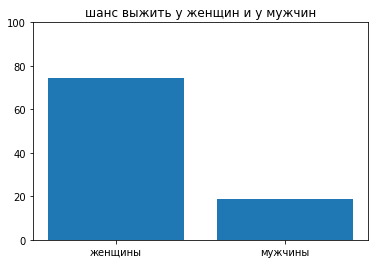

In [108]:
women = df[df.Sex == 'female'].Survived
ws = 100 * sum(women)/ len(women)
men = df[df.Sex == 'male'].Survived
ms = 100 * sum(men)/ len(men)
plt.bar(np.arange(2), [ws, ms])
plt.title('шанс выжить у женщин и у мужчин')
plt.xticks(np.arange(2), ['женщины', 'мужчины'])
plt.ylim((0,100))

Женщины более живучие (74 % выживших против 18 %)! Судя по фильму, их просто первыми сажали в лодки.

(62.962962962962962, 47.282608695652172, 24.236252545824847)

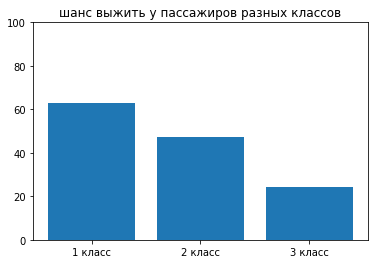

In [109]:
first = df[df.Pclass == 1]
fs = 100 * sum(first.Survived)/ len(first)
second = df[df.Pclass == 2]
ss = 100 * sum(second.Survived)/ len(second)
third = df[df.Pclass == 3]
ts = 100 * sum(third.Survived)/ len(third)
plt.bar(np.arange(3), [fs, ss, ts])
plt.title('шанс выжить у пассажиров разных классов')
plt.xticks(np.arange(3), ['1 класс', '2 класс', "3 класс"])
plt.ylim((0,100))
fs, ss, ts

Блаженны нищие, а выживут богатые // - 63 %, 47 %, 24 % выживших в первом, втором и третьем классе соответственно.

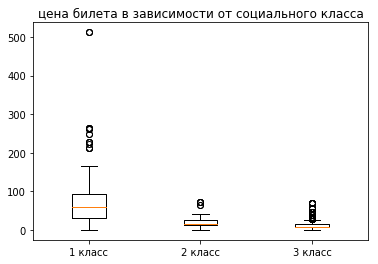

In [110]:
data = [df.Fare[df.Pclass == 1], df.Fare[df.Pclass == 2], df.Fare[df.Pclass == 3]]

plt.boxplot(data)
plt.xticks(np.arange(3) + 1, ('1 класс','2 класс','3 класс'))
plt.title('цена билета в зависимости от социального класса')

У богатых билеты дороже, не очень неожиданно. Наверное, стоит убрать за пределы графика фриков из первого класса, купивших билеты в 5-10 раз дороже, чем все остальные, чтобы лучше было видно разницу между 2-м и 3-м классом. Еще подозрительны люди, купившие билет забесплатно, лучше без них.

('medians', 61.979199999999999, 15.0229, 8.0500000000000007)

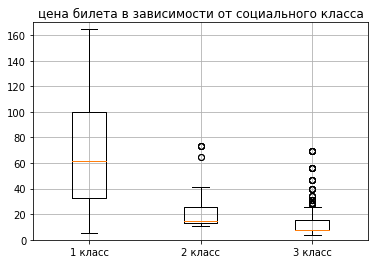

In [111]:
data = [df.Fare[(df.Pclass == 1)&(0 < df.Fare)], df.Fare[(df.Pclass == 2)&(0 < df.Fare)], df.Fare[(df.Pclass == 3)&(0 < df.Fare)]]

plt.boxplot(data)
plt.xticks(np.arange(3) + 1, ('1 класс','2 класс','3 класс'))
plt.title('цена билета в зависимости от социального класса')
plt.grid()
plt.yscale('linear', linscale = 10)
plt.ylim((0,170))
'medians', np.median(df.Fare[(df.Pclass == 1)&(0 < df.Fare)]), np.median(df.Fare[(df.Pclass == 2)&(0 < df.Fare)]), np.median(df.Fare[(df.Pclass == 3)&(0 < df.Fare)])

Интересно, что медиана в первом классе медиана где-то посередине, а во втором и третьем ближе к нижнему квартилю. Наверное, это должно значить, что доходы растут не линейно, а намного быстрее.

(0, 110)

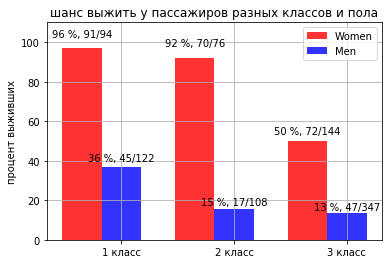

In [112]:
def persentage(x):
    return sum(x)*100/len(x)

n_groups = 3
ff = first[first.Sex == 'female'].Survived
sf = second[second.Sex == 'female'].Survived
tf = third[third.Sex == 'female'].Survived
fm = first[first.Sex == 'male'].Survived
sm = second[second.Sex == 'male'].Survived
tm = third[third.Sex == 'male'].Survived
means_women = (persentage(ff), persentage(sf), persentage(tf))
means_men = (persentage(fm), persentage(sm), persentage(tm))
 
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, means_women, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Women')
women_nom = (sum(ff), sum(sf), sum(tf))
men_nom = (sum(fm), sum(sm), sum(tm))
women_all = (len(ff), len(sf), len(tf))
men_all = (len(fm), len(sm), len(tm))
 
rects2 = plt.bar(index + bar_width, means_men, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Men')
 

plt.ylabel('процент выживших')
plt.xticks(index + bar_width, ('1 класс', '2 класс', '3 класс'))
plt.legend()
plt.title('шанс выжить у пассажиров разных классов и пола')
plt.grid()
def autolabel(rects, nombers, allto):
    i = 0
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                str('%d' % int(height)) + ' %, ' + str(nombers[i]) + '/' + str(allto[i]),
                ha='center', va='bottom')
        i += 1

autolabel(rects1, women_nom, women_all)
autolabel(rects2, men_nom, men_all)
plt.ylim(0, 110)


Вероятность выжить в каждой категории подписана на графике.
Как видно, гендерное неравенство сильнее классового: женщин третьего класса выжило больше, чем мужчин первого!

Запишу в виде формул: - В - человек выживет, Ж - человек женщина, I - человек первого класса.

Всего у нас 891 человек, но это число можно не использовать, потому что везде всё равно оно должно посокращаться.

Всего у нас выживших 342 человека. В = 342. 

Женщин у нас было 314. Ж = 314.

В первом классе ехало 216 человек. I = 216.

Выживших женщин 233. В&Ж = 233.

Выживших в первом классе I&B = 136.

Человек выживет при условии, что он женщина В | Ж = 74 % (из предыдущего графика). Проверим по формуле Байеса, что я нигде не запуталась. В | Ж = B&Ж : Ж = 233 : 314 = 74 %. Всё правильно!

Аналогично В | М = 18 %, В | I = 63 %, B | II = 47 %, B | III = 24 %

Человек женщина при условии, что он выжил - Ж | B = B&Ж : B = 233 : 342 = 68 % - неудивительно, если видим выжевшего человека, можно с уверенностью утверждать что скорее всего это женщина 

Человек принадлежит первому классу при условии, что он выжил I | B = I&B : B = 136 : 342 = 40 % - а вот так не работает, всего лишь 40 прц (ведь гендерное неравенство сильнее классового!). Первый класс сам по себе  не очень хорошо помогает выжить.

In [113]:
df = df.fillna(df.median(axis=0), axis=0)
x_labels = ['Pclass', 'Fare', 'Age', 'Sex', 'SibSp']
X, y = df[x_labels], df['Survived']
X = pandas.get_dummies(X)
X.head()

,Pclass,Fare,Age,SibSp,Sex_female,Sex_male
PassengerId,,,,,,
1,3,7.2500,22.0,1,0,1
2,1,71.2833,38.0,1,1,0
3,3,7.9250,26.0,0,1,0
4,1,53.1000,35.0,1,1,0
5,3,8.0500,35.0,0,0,1


In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# DecisionTree

In [115]:
clf = DecisionTreeClassifier(min_samples_split=5)
gs_clf = GridSearchCV(clf, {'max_leaf_nodes': (-5, -4, -3, -2, -1, None, 2, 3, 4, 5, 6, 7, 8)})
gs_clf.fit(np.array(X_train), np.array(y_train))
print(gs_clf.best_estimator_)
for model in gs_clf.grid_scores_:
    print(model, model[2])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=7, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
mean: 0.75923, std: 0.01249, params: {'max_leaf_nodes': -5} [ 0.74162679  0.76811594  0.76811594]
mean: 0.76565, std: 0.01684, params: {'max_leaf_nodes': -4} [ 0.74641148  0.78743961  0.76328502]
mean: 0.76726, std: 0.01479, params: {'max_leaf_nodes': -3} [ 0.74641148  0.77777778  0.77777778]
mean: 0.76083, std: 0.01485, params: {'max_leaf_nodes': -2} [ 0.74162679  0.77777778  0.76328502]
mean: 0.76244, std: 0.01827, params: {'max_leaf_nodes': -1} [ 0.73684211  0.77777778  0.77294686]
mean: 0.76244, std: 0.01528, params: {'max_leaf_nodes': None} [ 0.74162679  0.77777778  0.76811594]
mean: 0.78331, std: 0.01581, params: {'max_leaf_nodes': 2} [ 0.784689    0.80193237  0.76328502]
mean

Попробуем менять максимальное количество узлов. Не знаю, почему. Еще совершенно не понимаю, как он понимает отрицательные значения, хотя некоторые из них дают неплохой результат. Как видно, он выбрал число 7. Почему семь работает лучше остальных? No idea.

In [116]:
y_pred = gs_clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.89      0.86       158
          1       0.82      0.73      0.77       110

avg / total       0.82      0.82      0.82       268



In [117]:
dotfile = open("dtreemy.dot", 'w')
export_graphviz(gs_clf.best_estimator_, out_file = dotfile, feature_names = X_train.columns)
dotfile.close()

with open("dtreemy.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

RuntimeError: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' path

сохранить нужное дерево в dot файл получается, а вот превратить его потом в картинку - нет :(

# Random Forest ##

In [118]:
model = RandomForestClassifier(min_samples_split=5)

попробуем изменять количество деревьев в лесу

In [119]:
t1 = time.clock()
gs_mod = GridSearchCV(model, {'n_estimators': list(range(2, 400))})
gs_mod.fit(np.array(X_train), np.array(y_train))
print(time.clock() - t1, 'seconds for ', len(list(range(2, 400))))
print(gs_mod.best_estimator_)

865.749276309587 seconds for  398
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=18, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


Лучше всего должно работать со 104 деревьями

In [120]:

y_pred_forest = gs_mod.predict(X_test)
print(classification_report(y_test, y_pred_forest))

             precision    recall  f1-score   support

          0       0.85      0.89      0.87       158
          1       0.83      0.77      0.80       110

avg / total       0.84      0.84      0.84       268



Ну, ожидалось, что лес лучше одного дерева, но на практике разницы - практически никакой.

# сравнение моделей

Вообще-то модели получились почти одинаковые, так что это немного глупо, ну ладно. Чтобы было поинтереснее, сделаем еще один лес с плохими параметрами (самыми плохими).

In [137]:
bad_param = sorted(gs_mod.grid_scores_, key=lambda themodel: themodel.mean_validation_score)[0].parameters
bad_forest = RandomForestClassifier(n_estimators = bad_param['n_estimators'])
bad_forest.fit(np.array(X_train), np.array(y_train))
y_pred_bad_forest = bad_forest.predict(X_test)
print(bad_param)
print(classification_report(y_test, y_pred_bad_forest))

{'n_estimators': 3}
             precision    recall  f1-score   support

          0       0.84      0.82      0.83       158
          1       0.75      0.77      0.76       110

avg / total       0.80      0.80      0.80       268



Мда, не то чтобы получился сильно другой результат...

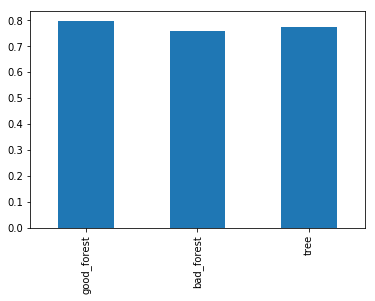

In [138]:

scores = {'tree': f1_score(y_test, y_pred), 'good_forest': f1_score(y_test, y_pred_forest), 'bad_forest': f1_score(y_test, y_pred_bad_forest)}

pandas.DataFrame.from_dict(data = scores, orient='index').plot(kind='bar', legend=False)

Супер-информативная диаграмма! Построим ROC-кривую.

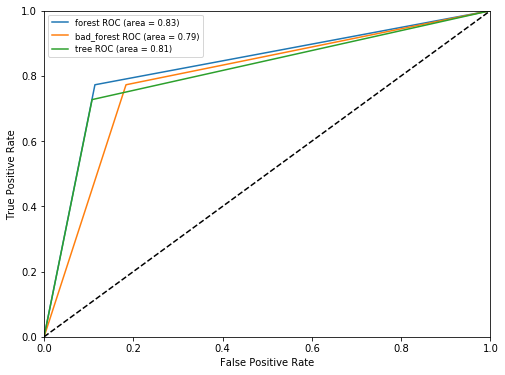

In [139]:

pl.clf()
plt.figure(figsize=(8,6))


fpr, tpr, thresholds = roc_curve(y_test, y_pred_forest)
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('forest', roc_auc))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_bad_forest)
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('bad_forest', roc_auc))


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('tree', roc_auc))


pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

Леса почти не видно, потому что он под деревом... Вообще нормальные модели лучше чем плоой лес, кривая выше. 